In [1]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class HDF5Dataset(Dataset):
    def __init__(self, h5_file, transform=None):
        self.h5_file = h5_file
        self.transform = transform
        with h5py.File(self.h5_file, 'r') as f:
            self.data = f['X_jets'][:] 
            self.labels = f['y'][:] 
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  
        label = self.labels[idx] 
        
        img = np.transpose(img, (2, 0, 1)) 

        if self.transform:
            img = self.transform(img)
        
        return img, label 

h5_file = 'quark-gluon_data-set_n139306.hdf5'

with h5py.File(h5_file, 'r') as f:
    x_jets = f['X_jets'][:] 
    mean_val = np.mean(x_jets)
    std_val = np.std(x_jets)

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.Normalize(mean=[mean_val], std=[std_val])  
])

dataset = HDF5Dataset(h5_file, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

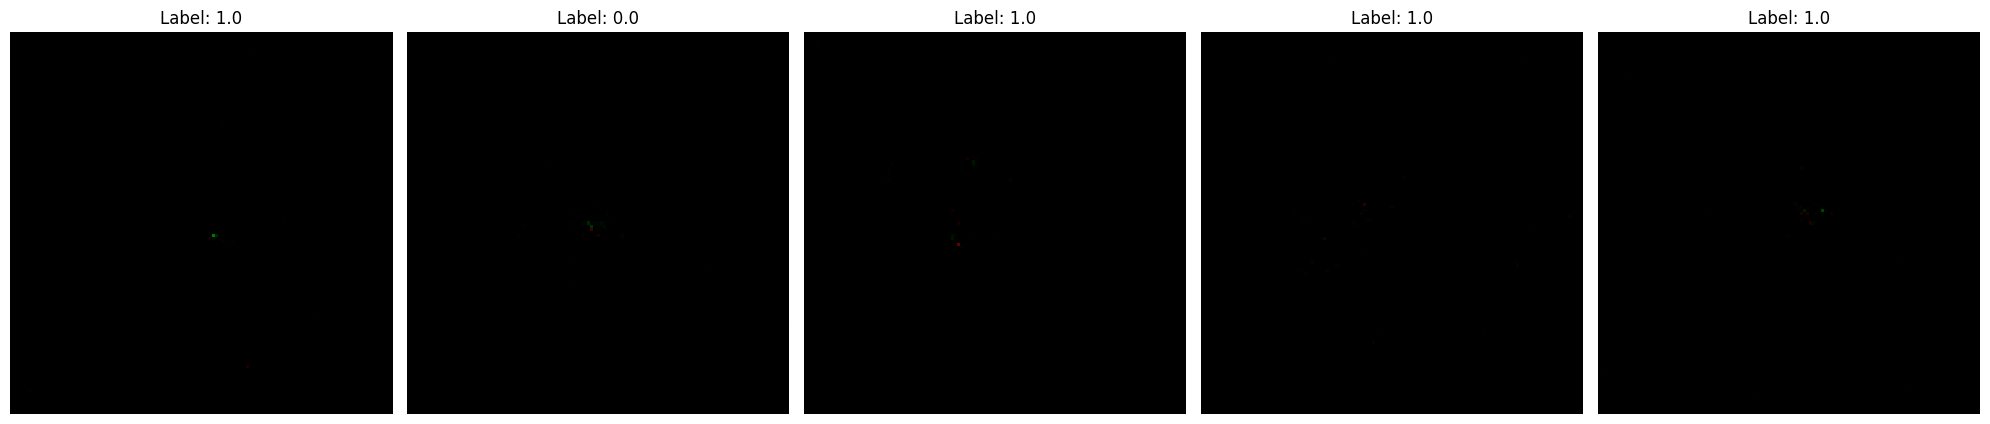

In [3]:
sample_data, sample_labels = next(iter(train_loader))

def denormalize(tensor, mean, std):
    return tensor * std + mean

sample_data = denormalize(sample_data, mean_val, std_val).cpu().numpy()

n = 5
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    img = np.transpose(sample_data[i], (1, 2, 0)) 
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"Label: {sample_labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )  

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )  

        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        ) 

        self.encoder4 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )  

        self.encoder5 = nn.Sequential( 
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
        )  

        self.decoder5 = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        ) 

        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        ) 

        self.conv4 = nn.Sequential(
            nn.Conv2d(16 + 16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ) 

        self.conv3 = nn.Sequential(
            nn.Conv2d(32 + 32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )  

        self.conv2 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )  

        self.conv1 = nn.Sequential(
            nn.Conv2d(64 + 3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1) 
        )

    def forward(self, x):
        e1 = self.encoder1(x) 
        e2 = self.encoder2(e1) 
        e3 = self.encoder3(e2) 
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4) 

        d5 = self.decoder5(e5) 
        d5 = torch.cat([d5, e4], dim=1)

        d4 = self.decoder4(d5)  
        d4 = self.conv4(torch.cat([d4, e3], dim=1))

        d3 = self.decoder3(d4) 
        d3 = self.conv3(torch.cat([d3, e2], dim=1))

        d2 = self.decoder2(d3)  
        d2 = F.interpolate(d2, size=e1.shape[2:], mode='nearest')
        d2 = self.conv2(torch.cat([d2, e1], dim=1))

        d1 = self.decoder1(d2) 
        x_resized = F.interpolate(x, size=d1.shape[2:], mode='nearest')
        d1 = self.conv1(torch.cat([d1, x_resized], dim=1))

        out = F.interpolate(d1, size=(125, 125), mode='nearest')
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetAutoencoder().to(device)

criterion = nn.L1Loss()  
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)  #(256, 1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=5e-6)


Epoch 1/30, Train Loss: 0.0074
Epoch 1/30, Test Loss: 0.0043
Epoch 2/30, Train Loss: 0.0029
Epoch 2/30, Test Loss: 0.0011
Epoch 3/30, Train Loss: 0.0010
Epoch 3/30, Test Loss: 0.0023
Epoch 4/30, Train Loss: 0.0007
Epoch 4/30, Test Loss: 0.0004
Epoch 5/30, Train Loss: 0.0006
Epoch 5/30, Test Loss: 0.0004
Epoch 6/30, Train Loss: 0.0006
Epoch 6/30, Test Loss: 0.0004
Epoch 7/30, Train Loss: 0.0005
Epoch 7/30, Test Loss: 0.0009
Epoch 8/30, Train Loss: 0.0005
Epoch 8/30, Test Loss: 0.0004
Epoch 9/30, Train Loss: 0.0004
Epoch 9/30, Test Loss: 0.0028
Epoch 10/30, Train Loss: 0.0004
Epoch 10/30, Test Loss: 0.0002
Epoch 11/30, Train Loss: 0.0003
Epoch 11/30, Test Loss: 0.0008
Epoch 12/30, Train Loss: 0.0003
Epoch 12/30, Test Loss: 0.0001
Epoch 13/30, Train Loss: 0.0003
Epoch 13/30, Test Loss: 0.0007
Epoch 14/30, Train Loss: 0.0003
Epoch 14/30, Test Loss: 0.0002
Epoch 15/30, Train Loss: 0.0003
Epoch 15/30, Test Loss: 0.0013
Epoch 16/30, Train Loss: 0.0002
Epoch 16/30, Test Loss: 0.0002
Epoch 17/3

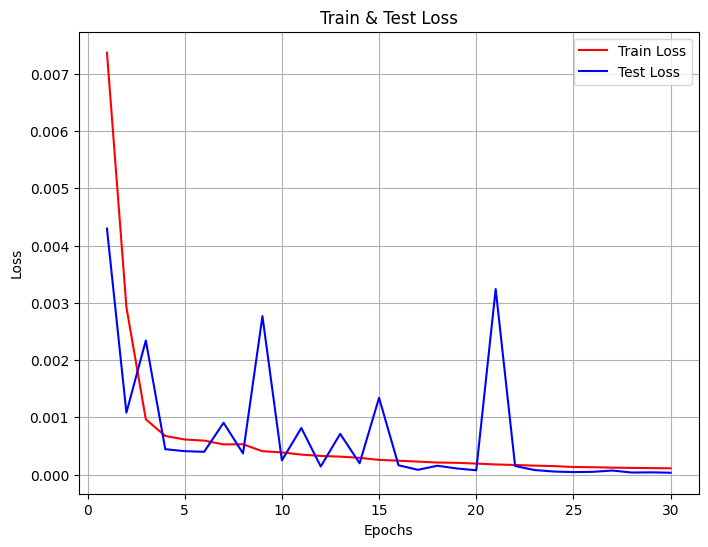

In [5]:
num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_running_loss += loss.item() * inputs.size(0)
    test_loss = test_running_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}")


plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='red', linewidth=1.5)
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', color='blue', linewidth=1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()
plt.grid(True)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.637979e-12..0.13784485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0090458..12.451563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.637979e-12..0.3647164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011137957..32.961605].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.637979e-12..0.22860943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009182201..20.661564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

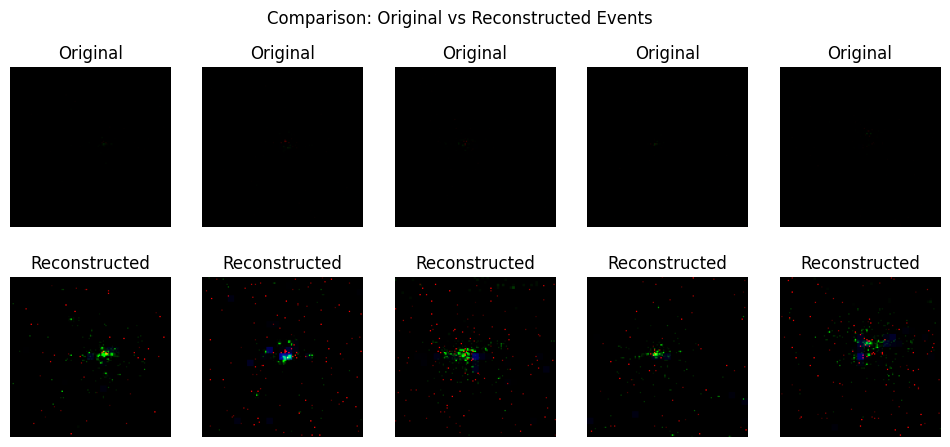

In [6]:
model.eval()

with torch.no_grad():
    sample_data, _ = next(iter(test_loader))
    sample_data = sample_data.to(device)
    reconstructions = model(sample_data)

num_samples = 5
sample_data = sample_data[:num_samples].cpu()
sample_data = denormalize(sample_data, mean_val, std_val)
reconstructions = reconstructions[:num_samples].cpu()

fig, axes = plt.subplots(2, num_samples, figsize=(12, 5))

for i in range(num_samples):
    axes[0, i].imshow(sample_data[i].permute(1, 2, 0).numpy(), cmap='viridis')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(reconstructions[i].permute(1, 2, 0).numpy(), cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.suptitle("Comparison: Original vs Reconstructed Events")
plt.show()
